# Data Cleaning

<b>Contents</b>

2. [Introduction](#2) <br>
    2.1. [Unpivoting dataframe](#2.1) <br>
    2.2. [Merge Volume, Speed and Occupancy](#2.2) <br>
    2.3. [Traditional missing data handling: Interpolation() and fillna()](#2.3) <br>
    2.4. [RNN time series imputation](#2.4) <br>
    2.5. [Merge incident type to Link All Days data by ID and DateTime](#2.5) 

<b>Input:</b>

- Smart Freeways Data 2018 - Links All Days.xlsx

14 Links' per minute time series data from 1 Jan 2018 to 25 Oct 2018

       - Sheet 1: NPI Links - Volume    (data available up to 1 Nov 18)
       - Sheet 2: NPI Links - Speed     (data available up to 25 Oct 18)
       - Sheet 3: NPI Links - Occupancy (data available up to 25 Oct 18)
    
- [Minor_Incidents_Log2.xlsx](data/Minor_Incidents_Log2.xlsx)

Incident Data on Kwinana Fwy from 1 Jan 2018 to 30 Nov 2018)

<b>Output:</b>

- [LAD.csv](data/LAD.csv)

The new dataframe consists of 298 days $\times$ 1440 mins $\times$ 14 links = 6007680 rows

|ID|DateTime|Length|Volume|Speed|Occupancy|
|--|--------|------|------|-----|---------|
|int|datetimens[64]|float32|int|float32|float32|

- [LAD+incident.csv](data/LAD+incident.csv)
|ID|DateTime|Length|Volume|Speed|Occupancy|Incident_type|
|--|--------|------|------|-----|---------|--------|
|int|datetimens[64]|float32|int|float32|float32|object|


# Introduction <a class="anchor" id="2"></a>

The <b>Smart Freeways Data 2018 - Links All Days.xlsx</b> file contains per minute data from Kwinana Freeway (Inner) Northbound on 14 NPI links, from 1 January to 25 October 2018. The excel file consists of three spreadsheets of 299 columns and 20515 rows, each summarising speed, volume and occupancy in pivot table layout. Each column represents date in `DD Mon YY` format, whereas each row represents time in `HH:MM` format, respectively. In addition, the length of each NPI link (in metre) is given. 

To facilitate the data exploration and analysis, the data frame is reshaped into long format so that each row is one time point per attribute, and the three spreadsheets are merged on timestamps and NPI Link. The new dataframe then consists of 6007680 rows (298 days $\times$ 1440 mins $\times$ 14 NPI links) and 6 columns, namely `NPI Link name`, `DateTime`, `Length`, `Volume`, `Speed` and `Occupancy`.

For accessibility of each NPI Link data, the new column, `ID`, is introduced to encode NPI Link name with values between 1 and 14. The mapping of a label encoder and the sample data frame structure are shown as follows:

| ID | Link Description |
|---------|---------------|
|1|Kwinana Fwy NB between Kwinana Fwy Nth Bnd H015 Nth Bnd - H018 East Bnd & Kwinana Fwy Nth Bnd H018 W|
|2|Kwinana Fwy NB between Kwinana Fwy Nth Bnd H018 West Bnd - H015 Nth Bnd & Farrington Rd On - H015 Nt|
|3|Kwinana Fwy NB between Farrington Rd On - H015 Nth Bo & H015 Nth Bound - South St Off|
|4|Kwinana Fwy NB between H015 Nth Bound - South St Off & South St On - H015 Nth Bound|
|5|Kwinana Fwy NB between South St On - H015 Nth Bound & H015 Nth Bound - Leach Hwy Off|
|6|Kwinana Fwy NB between H015 Nth Bound - Leach Hwy Off & Leach Hwy West Bound On - H015|
|7|Kwinana Fwy NB between Leach Hwy West Bound On - H015 & Leach Hwy East Bound On - H015|
|8|Kwinana Fwy NB between Leach Hwy East Bound On - H015 & Cranford Av On - H015 Nth Bou|
|9|Kwinana Fwy NB between Cranford Av On - H015 Nth Bou & H015 Sth Bound - H548|
|10|Kwinana Fwy NB between H015 Sth Bound - H548 & Manning Rd - H547 On Kwinana Fwy Nth Bound|
|11|Kwinana Fwy NWB between Manning Rd - H547 On Kwinana Fwy Nth Bound & Canning Hwy - H549 On Kwinana F|
|12|Kwinana Fwy NB between Kwinana Fwy (northbound) Bus Ln From Canning Hwy: H013 On To H015 Northbound|
|13|Kwinana Fwy NB between Mill Pt Rd - H500 On Kwinana Fwy Nth Bound & Kwinana Fwy Nth Bound H503 Off -|
|14|Kwinana Fwy NB between Kwinana Fwy Nth Bound H503 Off - Mill Pt Rd & Mitchell Fwy Nth Bound|



|ID|DateTime|Length|Volume|Speed|Occupancy|
|--|--------|------|------|-----|---------|
|int|datetimens[64]|float32|int|float32|float32|

Prior to feeding the data to conduct simulation or perform deep learning tasks, it is essential to perform an exploratory data analysis to determine the necessity of data engineering and to get insightful information about data features. Time series data such as traffic information are known to suffer from missing values problem due to various unexpected incidents, e.g. broken sensors or faulty detectors. These incomplete time series data are not only difficult to utilise, they also affect the performance of simulation and forecasting tasks. Therefore, time series data imputation has to be carried out with utmost care.


In this section, data cleaning is conducted alongside with the study of missing values distribution.



From quick data inspection, there are approximately 0.5% missing data from each spreadsheet, including the date 25th and 26th of March 2018. Traditionally, these data points with missing values can either be ignored altogether or fill in with median or mean values. The proposed traditional method for the data frame is to fill in the small data gap with less than 5 consecutive missing rows using linear interpolation, whereas the large data gap with more than or equal to 5 consecutive missing rows are filled in using the average values grouped by NPI link name, day of week and time.


Although, the traditional method seems to be sufficient, there is still a risk of losing essential information from the data due to oversummarising. Recently, deep learning models such as recurrent neural networks (RNN) have gained great many attentions in multivariate time series imputation as they are known to best captures time information from data.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# tensorflow
import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Conv1D, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

# Common imports
import os
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from datetime import date
import holidays
sns.set()
import warnings
warnings.filterwarnings("ignore")

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.sans-serif"] = "Verdana"
mpl.rcParams["lines.markersize"] = 20
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [2]:
df = pd.read_excel("data/Smart Freeways Data 2018 - Links All Days.xlsx",
                   sheet_name='NPI Links - Volume', skiprows=2, header=0)
df2 = pd.read_excel("data/Smart Freeways Data 2018 - Links All Days.xlsx",
                   sheet_name='NPI Links - Speed', skiprows=2, header=0)
df3 = pd.read_excel("data/Smart Freeways Data 2018 - Links All Days.xlsx",
                   sheet_name='NPI Links - Occupancy', skiprows=2, header=0)

## Unpivoting dataframe <a class="anchor" id="2.1"></a>

In [3]:
# Restructure columns so that we have all the dates
cols1 = df.columns[:3]
cols2 = [d.strftime('%d %b %y') for d in pd.date_range(start='2018-01-01',
                                               end='2018-10-25',
                                               freq='D')]
cols = [*cols1, *cols2]

In [4]:
def unpivot_data(df):
    """
    Function to add missing date columns and unpivot
    Smart Freeways Data 2018 - Links All Days.xlsx data file
    """
    # Missing Row Labels and NPI Link Length filled 
    df[['Row Labels', 'NPI Link Length']] = df[['Row Labels', 'NPI Link Length']].fillna(method='ffill')
    
    # Keep rows that have %H:%M time format
    df = df[df['Hour Formatted'].notna()]
    df = df[df['Hour Formatted'].str.len() <= 5]
    
    # Add 25 Mar 18 and/or 26 Mar 18 if one of either of them do not exist
    df = df.reindex(df.columns.union(cols, sort=False), axis=1)
    
    # Replace 24-27 Mar with 17-20 Mar
    # df['24 Mar 18'] = df['17 Mar 18']
    # df['25 Mar 18'] = df['18 Mar 18']
    # df['26 Mar 18'] = df['19 Mar 18']
    # df['27 Mar 18'] = df['20 Mar 18']
    
    # Change date columns' format from %d %b %y to %Y-%m-%d datetime
    aslist = df.columns.tolist()
    aslist[3:] = pd.to_datetime(df.columns[3:])
    df.columns = aslist
    
    # Change Hour Formatted column to datetime object
    df['Hour Formatted'] = pd.to_datetime(df['Hour Formatted'],
                                              format='%H:%M')
    
    # Melt (unpivot) dataframe
    df = df.melt(id_vars=['Row Labels', 'NPI Link Length', 'Hour Formatted'],
                  var_name='DateTime', value_name='Value')
    # Create DateTime column from date columns and HourFormatted
    df['DateTime'] = (pd.to_datetime(df['DateTime']) +  
                       pd.to_timedelta(df.pop('Hour Formatted')
                                       .dt.strftime('%H:%M:%S')))
    # Sort dataframe by Row Labels and DateTime
    df = df.sort_values(['Row Labels', 'DateTime'], 
                          ascending=[True, True])
    df.reset_index(drop=True, inplace=True)
    
    return df

vol_df = unpivot_data(df)  # 1 Jan 2018 - 1 Nov 2018
spe_df = unpivot_data(df2) # 1 Jan 2018 - 25 Oct 2018
occ_df = unpivot_data(df3) # 1 Jan 2018 - 25 Oct 2018

In [5]:
# Rename columns
vol_df.rename({'Row Labels': 'Link',
               'NPI Link Length': 'Length',
               'Value': 'Volume'}, axis=1, inplace=True)
spe_df.rename({'Row Labels': 'Link',
               'NPI Link Length': 'Length',
               'Value': 'Speed'}, axis=1, inplace=True)
occ_df.rename({'Row Labels': 'Link',
               'NPI Link Length': 'Length',
               'Value': 'Occupancy'}, axis=1, inplace=True)

In [6]:
vol_df # 305 days * 1440 mins * 14 Links = 6148800

,Link,Length,DateTime,Volume
0,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:00:00,16.0
1,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:01:00,15.0
2,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:02:00,15.0
3,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:03:00,15.0
4,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:04:00,14.0
...,...,...,...,...
6148795,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-11-01 23:55:00,5.0
6148796,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-11-01 23:56:00,5.0
6148797,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-11-01 23:57:00,5.0
6148798,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-11-01 23:58:00,5.0


In [7]:
spe_df # 298 days * 1440 mins * 14 Links = 6007680

,Link,Length,DateTime,Speed
0,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:00:00,80.000000
1,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:01:00,93.999998
2,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:02:00,93.999998
3,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:03:00,95.000000
4,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:04:00,96.999999
...,...,...,...,...
6007675,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-10-25 23:55:00,96.999997
6007676,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-10-25 23:56:00,96.999997
6007677,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-10-25 23:57:00,94.000001
6007678,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-10-25 23:58:00,94.000001


In [8]:
occ_df # 298 days * 1440 mins * 14 Links = 6007680

,Link,Length,DateTime,Occupancy
0,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:00:00,1.8
1,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:01:00,1.8
2,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:02:00,1.8
3,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:03:00,1.8
4,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,2018-01-01 00:04:00,1.8
...,...,...,...,...
6007675,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-10-25 23:55:00,0.0
6007676,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-10-25 23:56:00,0.0
6007677,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-10-25 23:57:00,0.0
6007678,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,2018-10-25 23:58:00,0.0


## Merge Volume, Speed and Occupancy <a class="anchor" id="2.2"></a>

In [9]:
# Merge volume and speed
dataset = vol_df.merge(spe_df, on=['Link','Length','DateTime'])

# Merge dataset and occupancy
dataset = dataset.merge(occ_df, on=['Link','Length','DateTime'])

In [22]:
# Map Link name to ID for convenience sake
dataset['ID'] = dataset['Link']
dataset = dataset.replace({'ID':{
    'Kwinana Fwy NB between Kwinana Fwy Nth Bnd H015 Nth Bnd - H018 East Bnd & Kwinana Fwy Nth Bnd H018 W': 1,
    'Kwinana Fwy NB between Kwinana Fwy Nth Bnd H018 West Bnd - H015 Nth Bnd & Farrington Rd On - H015 Nt': 2,
    'Kwinana Fwy NB between Farrington Rd On - H015 Nth Bo & H015 Nth Bound - South St Off': 3,
    'Kwinana Fwy NB between H015 Nth Bound - South St Off & South St On - H015 Nth Bound': 4,
    'Kwinana Fwy NB between South St On - H015 Nth Bound & H015 Nth Bound - Leach Hwy Off': 5,
    'Kwinana Fwy NB between H015 Nth Bound - Leach Hwy Off & Leach Hwy West Bound On - H015': 6,
    'Kwinana Fwy NB between Leach Hwy West Bound On - H015 & Leach Hwy East Bound On - H015': 7,
    'Kwinana Fwy NB between Leach Hwy East Bound On - H015 & Cranford Av On - H015 Nth Bou': 8,
    'Kwinana Fwy NB between Cranford Av On - H015 Nth Bou & H015 Sth Bound - H548': 9,
    'Kwinana Fwy NB between H015 Sth Bound - H548 & Manning Rd - H547 On Kwinana Fwy Nth Bound': 10,
    'Kwinana Fwy NWB between Manning Rd - H547 On Kwinana Fwy Nth Bound & Canning Hwy - H549 On Kwinana F': 11,
    'Kwinana Fwy NB between Kwinana Fwy (northbound) Bus Ln From Canning Hwy: H013 On To H015 Northbound': 12,
    'Kwinana Fwy NB between Mill Pt Rd - H500 On Kwinana Fwy Nth Bound & Kwinana Fwy Nth Bound H503 Off -': 13,
    'Kwinana Fwy NB between Kwinana Fwy Nth Bound H503 Off - Mill Pt Rd & Mitchell Fwy Nth Bound': 14,
}})

In [24]:
dataset.groupby(['ID','Link','Length']).count()

,,,DateTime,Volume,Speed,Occupancy
ID,Link,Length,,,,
1,Kwinana Fwy NB between Kwinana Fwy Nth Bnd H015 Nth Bnd - H018 East Bnd & Kwinana Fwy Nth Bnd H018 W,960.0,429120,425247,414812,425247
2,Kwinana Fwy NB between Kwinana Fwy Nth Bnd H018 West Bnd - H015 Nth Bnd & Farrington Rd On - H015 Nt,770.0,429120,425247,419945,425247
3,Kwinana Fwy NB between Farrington Rd On - H015 Nth Bo & H015 Nth Bound - South St Off,520.0,429120,425023,420225,425023
4,Kwinana Fwy NB between H015 Nth Bound - South St Off & South St On - H015 Nth Bound,1136.0,429120,425038,420934,425038
5,Kwinana Fwy NB between South St On - H015 Nth Bound & H015 Nth Bound - Leach Hwy Off,961.0,429120,425247,422211,425247
6,Kwinana Fwy NB between H015 Nth Bound - Leach Hwy Off & Leach Hwy West Bound On - H015,604.0,429120,425247,421270,425247
7,Kwinana Fwy NB between Leach Hwy West Bound On - H015 & Leach Hwy East Bound On - H015,493.0,429120,425031,420474,425031
8,Kwinana Fwy NB between Leach Hwy East Bound On - H015 & Cranford Av On - H015 Nth Bou,371.0,429120,425029,421769,425029
9,Kwinana Fwy NB between Cranford Av On - H015 Nth Bou & H015 Sth Bound - H548,2840.0,429120,425247,422402,425247


In [8]:
# Rearrange columns
dataset = dataset[['DateTime', 'ID', 'Link', 'Length',
                   'Volume', 'Speed', 'Occupancy']]
dataset

,DateTime,ID,Link,Length,Volume,Speed,Occupancy
0,2018-01-01 00:00:00,9,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,16.0,80.000000,1.8
1,2018-01-01 00:01:00,9,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,15.0,93.999998,1.8
2,2018-01-01 00:02:00,9,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,15.0,93.999998,1.8
3,2018-01-01 00:03:00,9,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,15.0,95.000000,1.8
4,2018-01-01 00:04:00,9,Kwinana Fwy NB between Cranford Av On - H015 N...,2840.0,14.0,96.999999,1.8
...,...,...,...,...,...,...,...
6007675,2018-10-25 23:55:00,11,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,5.0,96.999997,0.0
6007676,2018-10-25 23:56:00,11,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,5.0,96.999997,0.0
6007677,2018-10-25 23:57:00,11,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,5.0,94.000001,0.0
6007678,2018-10-25 23:58:00,11,Kwinana Fwy NWB between Manning Rd - H547 On K...,405.0,5.0,94.000001,0.0


In [9]:
dataset.describe()

,ID,Length,Volume,Speed,Occupancy
count,6.007680e+06,6.007680e+06,5.951682e+06,5.893280e+06,5.951682e+06
mean,7.500000e+00,1.060643e+03,3.907448e+01,8.866836e+01,5.005858e+00
std,4.031129e+00,1.077290e+03,2.903638e+01,1.225270e+01,5.322799e+00
min,1.000000e+00,3.710000e+02,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+00,4.900000e+02,1.000000e+01,8.700000e+01,1.000000e+00
50%,7.500000e+00,5.855000e+02,4.000000e+01,9.200000e+01,5.000000e+00
75%,1.100000e+01,9.610000e+02,6.200000e+01,9.500000e+01,7.300000e+00
max,1.400000e+01,4.272000e+03,1.340000e+02,2.550000e+02,6.490000e+01


# Visualisation  <a class="anchor" id="3"></a>

In [ ]:
df

In [38]:
df = dataset.copy()

In [39]:
# Change 0s in Volume column to NaNs
df['Volume'].replace(0, np.nan, inplace=True)
df['DateTime'] = df['DateTime'].astype('int64')


df = df[['Volume', 'Speed', 'Occupancy']].values

# Take rows with NaN's only
X = df[ np.isnan(df).any(axis=1)]

# Full trends
F = df[ ~np.isnan(df).any(axis=1)] 

In [48]:
# Number of consecutive NaNs in Volume column
# (dataset.Volume.isnull().astype(int)
#              .groupby(dataset.Volume.notnull().astype(int).cumsum()).sum()
#              .value_counts().sort_index())

0       5881800
1          3030
2          7172
3           772
4           493
5           300
6           181
7           154
8            93
9            72
10           68
11           70
12           52
13           25
14           14
15           15
16           13
17           11
18            9
19           11
20            5
21            2
22            3
23            3
24            4
25            2
26            2
27            3
28            2
32            1
33            1
34           13
38            1
60            1
169           1
184           1
186           1
207           3
212           3
218           2
228           2
236           1
237           1
312           1
856          14
1187          1
4647          1
4648         12
4649          1
Name: Volume, dtype: int64

In [58]:
X

array([[nan, nan,  0.],
       [nan, nan,  0.],
       [nan, nan,  0.],
       ...,
       [nan, nan,  0.],
       [nan, nan,  0.],
       [nan, nan,  0.]])

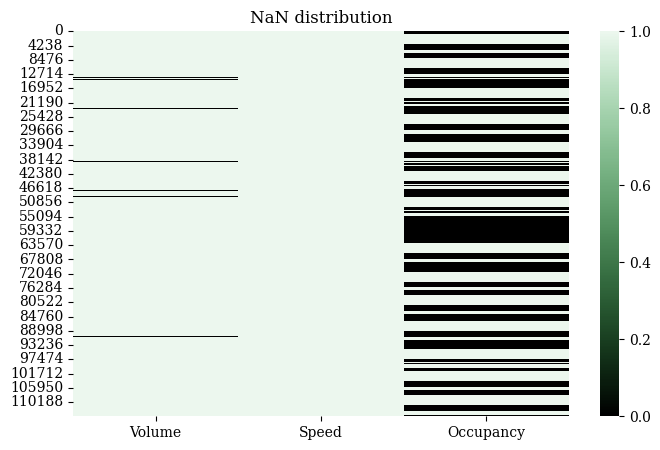

In [71]:
cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95,
                           reverse=True, as_cmap=True)

plt.figure(figsize=(8,5))
sns.heatmap(np.isnan(X), xticklabels=['Volume', 'Speed', 'Occupancy'],
            cmap=cmap)
plt.title('NaN distribution')
plt.show() 

The heatmap plot shows the distribution of missing values (NaNs) from each features. It appears that most of the NaNs are collectively missing from volume and speed data, 

# Data Imputation <a class="anchor" id="4"></a>

## Traditional: Interpolation() and fillna() <a class="anchor" id="4.1"></a>

- Assume that volume will never be zero at all time (at least 1), so 0s are replaced with NaNs.
- For small missing data gap (<5 consecutive NaNs), interpolate/extrapolate with hard limit = 5
- For large missing data gap (>=5 consecutive NaNs), fill NaNs with average (mean) values grouped by ID, day of week and timestamp.
- Round Volume and Occupancy values to integer and to 1 decimal place, respectively.

In [ ]:
# Change 0s in Volume column to NaNs
dataset['Volume'].replace(0, np.nan, inplace=True)

In [ ]:
# Check number of consecutive NaNs
vol_check = (dataset.Volume.isnull().astype(int)
             .groupby(dataset.Volume.notnull().astype(int).cumsum()).sum())
vol_check.value_counts().sort_index()

In [ ]:
# Multiindex dataframe
dat = dataset.set_index(['ID', 'DateTime'])
dat = dat.sort_index()

# Retrieve only Length, Volume, Speed, and Occupancy
dat = dat.iloc[:,-4:]; dat

In [ ]:
# For small missing data gap (<5 consecutive NaNs),
# interpolate/extrapolate with hard limit = 5
mask = dat.copy()
grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
grp['ones'] = 1
for i in dat.columns:
    mask[i] = (grp.groupby(i)['ones'].transform('count') < 5) | dat[i].notnull()

dat = dat.interpolate().bfill()[mask]

In [ ]:
# Only >=5 consecutive NaNs left
(dat.Volume.isnull().astype(int)
 .groupby(dat.Volume.notnull().astype(int).cumsum()).sum()
 .value_counts().sort_index())

In [ ]:
# Check average (mean) of values grouped by ID, day of week and timestamp
(dat.groupby([dat.index.get_level_values(0), 
             dat.index.get_level_values(1).strftime('%A %H:%M')])
 [['Volume','Speed','Occupancy']].mean())

In [ ]:
# For big missing data gap (>=5 consecutive NaNs),
# fill with average (mean) of the same day of week and time
# Group by index 0 and index 1 (ID and day of week timestamp)
dat[['Volume','Speed','Occupancy']] = (dat[['Volume','Speed','Occupancy']]
    .fillna(dat.groupby([dat.index.get_level_values(0), 
                         dat.index.get_level_values(1).strftime('%A %H:%M')])
           [['Volume','Speed','Occupancy']].transform('mean')))

In [ ]:
# Check number of consecutive NaNs for Volume
(dat.Volume.isnull().astype(int)
 .groupby(dat.Volume.notnull().astype(int).cumsum()).sum()
 .value_counts().sort_index())

In [ ]:
# Check number of consecutive NaNs for Speed
(dat.Speed.isnull().astype(int)
 .groupby(dat.Speed.notnull().astype(int).cumsum()).sum()
 .value_counts().sort_index())

In [ ]:
# Check number of consecutive NaNs for Occupancy
(dat.Occupancy.isnull().astype(int)
 .groupby(dat.Occupancy.notnull().astype(int).cumsum()).sum()
 .value_counts().sort_index())

In [ ]:
dat['Volume'] = round(dat['Volume']) # round to nearest integer
dat['Occupancy'] = round(dat['Occupancy']) # round to 1 dp

In [ ]:
dat

In [ ]:
# Save data as CSV
dat.to_csv('data/LAD.csv')

In [5]:
# Read LAD file if have not run from the beginning
df = pd.read_csv("data/LAD.csv", header=0)

In [6]:
df

,ID,DateTime,Length,Volume,Speed,Occupancy
0,1,2018-01-01 00:00:00,960.0,7.0,96.000000,1.0
1,1,2018-01-01 00:01:00,960.0,6.0,94.999998,1.0
2,1,2018-01-01 00:02:00,960.0,5.0,90.999999,1.0
3,1,2018-01-01 00:03:00,960.0,5.0,94.999997,1.0
4,1,2018-01-01 00:04:00,960.0,5.0,92.999999,1.0
...,...,...,...,...,...,...
6007675,14,2018-10-25 23:55:00,567.0,6.0,82.999997,0.0
6007676,14,2018-10-25 23:56:00,567.0,6.0,78.000003,0.0
6007677,14,2018-10-25 23:57:00,567.0,5.0,78.000001,0.0
6007678,14,2018-10-25 23:58:00,567.0,6.0,74.000000,0.0


## RNN Time Series imputation <a class="anchor" id="2.4"></a>

##  Merge incident type to Link All Days data by ID and nearest DateTime <a class="anchor" id="2.5"></a>

In [7]:
# Read Incident file
inc_df = pd.read_excel("data/Minor_Incidents_Log2.xlsx",
                   sheet_name='Sheet1', header=0)

In [8]:
# Drop crossRoadRef and rearrange columns
inc_df = inc_df[['ID', 'DateTime', 'Incident_type']]
inc_df

,ID,DateTime,Incident_type
0,14,2018-01-01 08:21:41,Break Down / Tow Away
1,9,2018-01-03 07:41:15,Break Down / Tow Away
2,9,2018-01-04 09:10:22,Break Down / Tow Away
3,7,2018-01-04 21:19:42,Road Crash
4,11,2018-01-09 01:10:00,Debris / Trees / Lost Loads
...,...,...,...
420,14,2018-11-23 09:32:18,Road Crash
421,11,2018-11-26 08:40:15,Break Down / Tow Away
422,11,2018-11-28 01:16:50,Break Down / Tow Away
423,11,2018-11-28 22:34:50,Break Down / Tow Away


In [15]:
# Round DateTime timestamp to the nearest minute
inc_df.DateTime = inc_df.DateTime.round('min')
inc_df

,ID,DateTime,Incident_type
0,14,2018-01-01 08:22:00,Break Down / Tow Away
1,9,2018-01-03 07:41:00,Break Down / Tow Away
2,9,2018-01-04 09:10:00,Break Down / Tow Away
3,7,2018-01-04 21:20:00,Road Crash
4,11,2018-01-09 01:10:00,Debris / Trees / Lost Loads
...,...,...,...
420,14,2018-11-23 09:32:00,Road Crash
421,11,2018-11-26 08:40:00,Break Down / Tow Away
422,11,2018-11-28 01:17:00,Break Down / Tow Away
423,11,2018-11-28 22:35:00,Break Down / Tow Away


In [35]:
# Check whether we have duplicate entries
# We does!
inc_df[inc_df.duplicated(subset=['ID','DateTime'], keep=False)]

,ID,DateTime,Incident_type
271,14,2018-07-21 22:56:00,Miscellaneous
272,14,2018-07-21 22:56:00,Road Crash


In [49]:
inc_df.iloc[271,1] = inc_df.iloc[271,1].replace(minute=55)

In [50]:
# Check again for duplicate ID and time
inc_df[inc_df.duplicated(subset=['ID','DateTime'], keep=False)]

,ID,DateTime,Incident_type


In [51]:
df.DateTime = pd.to_datetime(df.DateTime)
inc_df.DateTime = pd.to_datetime(inc_df.DateTime)
inc_df.sort_values('DateTime', inplace=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6007680 entries, 0 to 6007679
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   ID         int64         
 1   DateTime   datetime64[ns]
 2   Length     float64       
 3   Volume     float64       
 4   Speed      float64       
 5   Occupancy  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 275.0 MB


In [53]:
inc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 424
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             425 non-null    int64         
 1   DateTime       425 non-null    datetime64[ns]
 2   Incident_type  425 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 13.3+ KB


In [54]:
df_merged = (pd.merge(df.sort_values(['ID', 'DateTime']),
                      inc_df.sort_values(['ID', 'DateTime']),
                      how='left',
                      on=['ID', 'DateTime'])
             .sort_values(['ID', 'DateTime'])
             .reset_index()
            )
df_merged

,index,ID,DateTime,Length,Volume,Speed,Occupancy,Incident_type
0,0,1,2018-01-01 00:00:00,960.0,7.0,96.000000,1.0,NaN
1,1,1,2018-01-01 00:01:00,960.0,6.0,94.999998,1.0,NaN
2,2,1,2018-01-01 00:02:00,960.0,5.0,90.999999,1.0,NaN
3,3,1,2018-01-01 00:03:00,960.0,5.0,94.999997,1.0,NaN
4,4,1,2018-01-01 00:04:00,960.0,5.0,92.999999,1.0,NaN
...,...,...,...,...,...,...,...,...
6007675,6007675,14,2018-10-25 23:55:00,567.0,6.0,82.999997,0.0,NaN
6007676,6007676,14,2018-10-25 23:56:00,567.0,6.0,78.000003,0.0,NaN
6007677,6007677,14,2018-10-25 23:57:00,567.0,5.0,78.000001,0.0,NaN
6007678,6007678,14,2018-10-25 23:58:00,567.0,6.0,74.000000,0.0,NaN


In [62]:
df_merged = df_merged.iloc[:,1:]

In [55]:
df_merged.Incident_type.count()

397

In [63]:
# Save data as CSV
df_merged.to_csv('data/LAD+incident.csv', index=False)

# Visualisation <a class="anchor" id="3"></a>

In [ ]:
# Read LAD+incident file if have not run from the beginning
df = pd.read_csv("data/LAD+incident.csv", header=0)